# Lecture 23 - Literature Data Mining

## Learning goals

- Use LLMs to **classify literature abstracts** for experimental vs. non-experimental studies.  
- Apply **prompt engineering** and **domain heuristics** to improve classification consistency.  
- Extract **structured synthesis data** from full-text PDFs using reasoning and JSON schema outputs.  
- Understand how to perform **vision-based figure recognition** in papers.  

[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1aQPq-vP0DhK2_CyAK10vfuAmByIymruO?usp=sharing)


Note: It will be helpful to review "Lecture 20 - Large Language Models" before this class.

## 1. Setup



In [ ]:
import os
from io import BytesIO

import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
import requests

try:
  from PyPDF2 import PdfReader
  from pdf2image import convert_from_bytes
  PDF2IMAGE_AVAILABLE = True
except:
    !pip install PyPDF2 pdf2image
    from PyPDF2 import PdfReader
    from pdf2image import convert_from_bytes
    PDF2IMAGE_AVAILABLE = True

OPENAI_API_KEY = "sk-REPLACE WITH YOU API KEY"
# Create a client. This will read OPENAI_API_KEY from your environment.
client = OpenAI(api_key = OPENAI_API_KEY )

## 2. Loading and inspecting the paper list

Imagine that you exported a list of 100 or more papers from Web of Science as an Excel or CSV file.  

https://www.webofscience.com/wos/woscc/basic-search




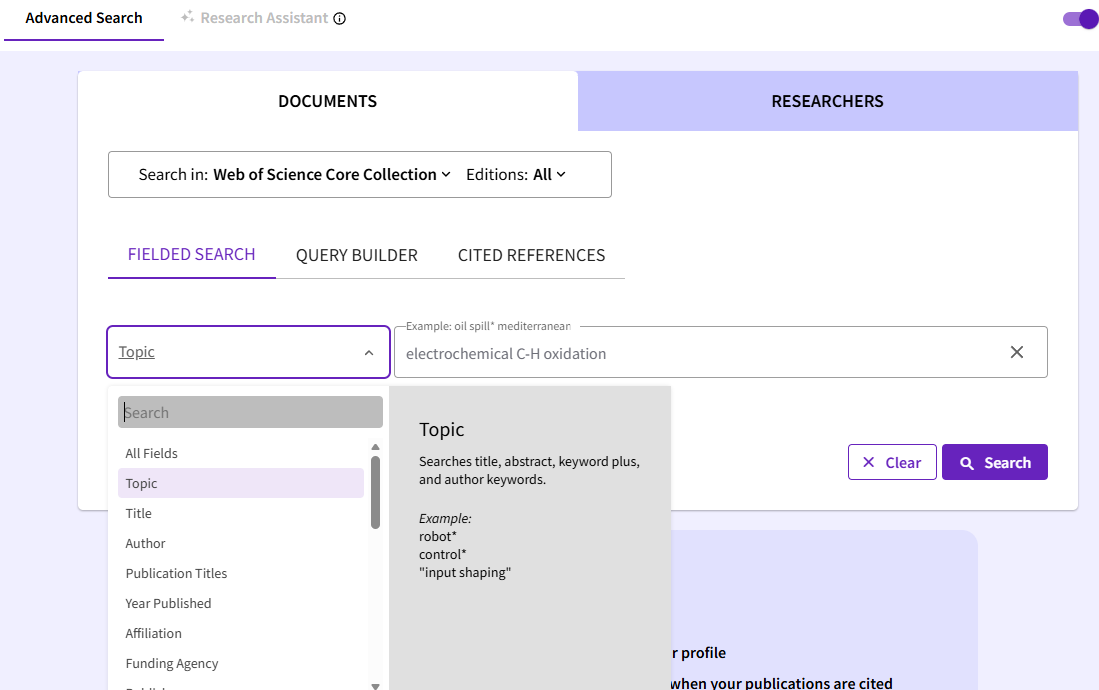

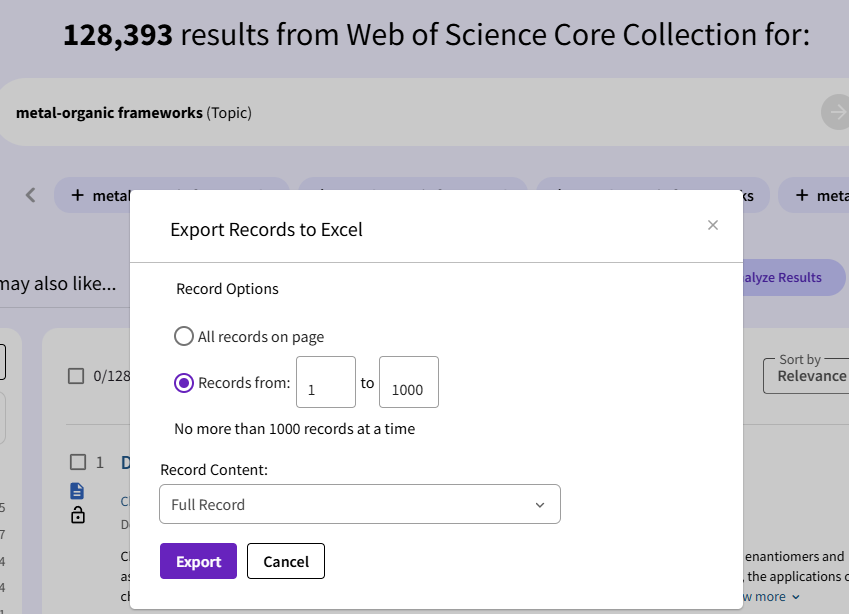



Here we work with a **small example dataset** that has the same structure but only a few rows.

The CSV is hosted on GitHub and contains columns:

- `doi`
- `paper_title`
- `abstract`
- `file_location` (a URL that points to the PDF of the paper)


In [2]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/data_mining_papers.csv"
df_raw = pd.read_csv(url)
df_raw = df_raw.dropna(how="all").reset_index(drop=True) #remove any empty rows
df_raw.head(6)


,doi,paper_title,abstract,file_location
0,10.1021/jacs.3c12086,Shaping the Water-Harvesting Behavior of Metal...,We construct a data set of metal–organic frame...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...
1,10.1021/acs.inorgchem.5c01817,Hydroxamate Linkage Transformation in Porphyri...,This study reports the discovery of five porph...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...
2,10.1016/j.matt.2025.102372,Ferrous nutritional metal-organic framework as...,Fortifying salt with both iron and iodine rema...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...
3,10.1021/jacs.3c11688,Crystalline Polyphenylene Covalent Organic Fra...,The synthesis of crystalline polyphenylene cov...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...
4,10.1021/acs.inorgchem.3c02322,Structural Chemistry of Zeolitic Imidazolate F...,Zeolitic imidazolate frameworks (ZIFs) are bas...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...
5,10.1038/s41467-020-18427-3,Ultralight covalent organic framework/graphene...,The fabrication of macroscopic objects from co...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...


In [3]:
print("Number of rows:", len(df_raw))
print("Columns:", list(df_raw.columns))


Number of rows: 6
Columns: ['doi', 'paper_title', 'abstract', 'file_location']


Let's view one row in a vertical format to understand the structure.

In [4]:
row0 = df_raw.iloc[0]
for col, val in row0.items():
    print(col + ":")
    print(" ", val)
    print("-" * 60)


doi:
  10.1021/jacs.3c12086
------------------------------------------------------------
paper_title:
  Shaping the Water-Harvesting Behavior of Metal–Organic Frameworks Aided by Fine-Tuned GPT Models
------------------------------------------------------------
abstract:
  We construct a data set of metal–organic framework (MOF) linkers and employ a fine-tuned GPT assistant to propose MOF linker designs by mutating and modifying the existing linker structures. This strategy allows the GPT model to learn the intricate language of chemistry in molecular representations, thereby achieving an enhanced accuracy in generating linker structures compared with its base models. Aiming to highlight the significance of linker design strategies in advancing the discovery of water-harvesting MOFs, we conducted a systematic MOF variant expansion upon state-of-the-art MOF-303 utilizing a multidimensional approach that integrates linker extension with multivariate tuning strategies. We synthesized a se

You should see that the dataset contains, for each paper:

- A DOI string such as `10.1021/jacs.3c12086`.
- A descriptive title.
- An abstract with several sentences.
- A `file_location` link that points to the full PDF (WoS does not come with this, you need to download the file by yourself via `DOI`).

In a real project the `file_location` would often be a local path like `pdf/10.1021_jacs.3c12086.pdf` rather than a web URL.


## 3. Using an LLM to classify abstracts to select papers

Keyword based filtering such as `"covalent organic framework" AND synthesis` is a useful starting point, but it can miss relevant papers or keep many false positives.

Here we build an LLM based **binary classifier** that looks at each abstract and answers:

> *Does this abstract describe an experimental synthesis of a covalent organic framework (COF)?*

The model should output a **single character**:

- `Y` if the abstract clearly or implicitly involves experimental synthesis of a COF.
- `N` otherwise, or if the abstract explicitly says there is no experimental work.

We first construct a prompt template as a Python function so that we can reuse it for every row in the DataFrame.


In [5]:
def make_simple_cof_prompt(title, doi, abstract):
    # Build a prompt that defines Y and N and asks for a single character output.
    prompt = (
        f"""You are a domain expert in covalent organic frameworks (COFs).
        Given the paper info (title and abstract), output a SINGLE uppercase letter.
        Y = The abstract indicates (explicitly OR implicitly) an experimental synthesis of a covalent organic framework.
        N = Otherwise, or if any explicit exclusion is present.
        Return ONLY 'Y' or 'N' (one character). No punctuation, words, or explanation.
        TITLE: {title}
        DOI: {doi}
        ABSTRACT: {abstract}"""
    )
    return prompt

example_prompt = make_simple_cof_prompt(
    df_raw.loc[0, "paper_title"],
    df_raw.loc[0, "doi"],
    df_raw.loc[0, "abstract"],
)
print(example_prompt[:600])


You are a domain expert in covalent organic frameworks (COFs).
        Given the paper info (title and abstract), output a SINGLE uppercase letter.
        Y = The abstract indicates (explicitly OR implicitly) an experimental synthesis of a covalent organic framework.
        N = Otherwise, or if any explicit exclusion is present.
        Return ONLY 'Y' or 'N' (one character). No punctuation, words, or explanation.
        TITLE: Shaping the Water-Harvesting Behavior of Metal–Organic Frameworks Aided by Fine-Tuned GPT Models
        DOI: 10.1021/jacs.3c12086
        ABSTRACT: We construct a d


The printed prompt fragment should show:

- The role sentence identifying the model as a COF expert.
- The definitions of `Y` and `N`.
- The strict formatting instruction to return only one character.
- The actual title, DOI, and abstract text for the first paper.

Now we send this prompt to the Responses API for a single example so that you can inspect the raw output.


In [6]:
def classify_single_paper_simple(row):
    # Build the prompt for a single row.
    prompt = make_simple_cof_prompt(row["paper_title"], row["doi"], row["abstract"])

    # Send a single user message containing the prompt.
    response = client.responses.create(
        model="gpt-5",
        input=[
            {
                "role": "user",
                "content": [
                    {"type": "input_text", "text": prompt},
                ],
            }
        ],
        reasoning={"effort": "medium"},
        max_output_tokens=200,
        store=False,
    )
    return response

example_response = classify_single_paper_simple(df_raw.iloc[0])
print("Type of response object:", type(example_response))
print("Raw output_text:", repr(example_response.output_text))


Type of response object: <class 'openai.types.responses.response.Response'>
Raw output_text: 'N'


Note that the reasoning is not required. You can change the models to simpler ones like `gpt-4o` and remove `reasoning={"effort": "medium"}`. It will also work.



Once the single example works we can **loop over the entire dataset** and create a new column `llm_simple_label` with the model answer for each abstract.


In [7]:
def classify_dataframe_simple(df):
    labels = []
    for idx, row in df.iterrows():
        print("Classifying row", idx, "with DOI", row["doi"])
        response = classify_single_paper_simple(row)
        label = response.output_text.strip()
        labels.append(label)
    df_out = df.copy()
    df_out["llm_simple_label"] = labels
    return df_out

df_raw_clean = df_raw.dropna(how="all") #remove any empty rows

df_simple = classify_dataframe_simple(df_raw_clean)
df_simple


Classifying row 0 with DOI 10.1021/jacs.3c12086
Classifying row 1 with DOI 10.1021/acs.inorgchem.5c01817
Classifying row 2 with DOI 10.1016/j.matt.2025.102372
Classifying row 3 with DOI 10.1021/jacs.3c11688
Classifying row 4 with DOI 10.1021/acs.inorgchem.3c02322
Classifying row 5 with DOI 10.1038/s41467-020-18427-3


,doi,paper_title,abstract,file_location,llm_simple_label
0,10.1021/jacs.3c12086,Shaping the Water-Harvesting Behavior of Metal...,We construct a data set of metal–organic frame...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,N
1,10.1021/acs.inorgchem.5c01817,Hydroxamate Linkage Transformation in Porphyri...,This study reports the discovery of five porph...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,N
2,10.1016/j.matt.2025.102372,Ferrous nutritional metal-organic framework as...,Fortifying salt with both iron and iodine rema...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,N
3,10.1021/jacs.3c11688,Crystalline Polyphenylene Covalent Organic Fra...,The synthesis of crystalline polyphenylene cov...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,Y
4,10.1021/acs.inorgchem.3c02322,Structural Chemistry of Zeolitic Imidazolate F...,Zeolitic imidazolate frameworks (ZIFs) are bas...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,N
5,10.1038/s41467-020-18427-3,Ultralight covalent organic framework/graphene...,The fabrication of macroscopic objects from co...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,Y


The new column `llm_simple_label` shows the basic screening decision for each paper.  
In a large dataset this would be your first pass filter before investing time in full text data mining.



## 4. Adding rationales and domain rules

The simple classifier is fast but opaque: it gives only `Y` or `N`.  
For scientific work it is helpful to also see **why** a decision was made.

We now extend the prompt in two ways:

1. Ask for a short **rationale line** explaining the decision.
2. Encode explicit **domain rules** that tell the model which textual cues are strong or weak evidence for synthesis.


### 4.1 Adding a short rationale

We modify the prompt so that the model returns two lines:

1. Line 1: `Y` or `N`  
2. Line 2: `rational: <short explanation>`

The rationale should be fewer than 20 words so that it fits nicely into a table.


In [8]:
def make_rationale_prompt(title, doi, abstract):
    prompt = (
        "You are a domain expert in COFs.\n"
        "Given the paper info (title and abstract), decide if experimental synthesis of a covalent organic framework is present.\n\n"
        "Return exactly two lines.\n"
        "Line 1: Y or N.\n"
        "Line 2: rational: <short explanation, fewer than 20 words>.\n\n"
        "Y = The abstract indicates (explicitly OR implicitly) an experimental synthesis of a covalent organic framework.\n"
        "N = Otherwise, or if any explicit exclusion is present.\n\n"
        f"TITLE: {title}\n"
        f"DOI: {doi}\n"
        f"ABSTRACT: {abstract}"
    )
    return prompt

def classify_single_with_rationale(row):
    prompt = make_rationale_prompt(row["paper_title"], row["doi"], row["abstract"])
    response = client.responses.create(
        model="gpt-5",
        input=[{"role": "user", "content": [{"type": "input_text", "text": prompt}]}],
        reasoning={"effort": "medium"},
        max_output_tokens=500,
        store=False,
    )
    text = response.output_text.strip()
    lines = [line.strip() for line in text.splitlines() if line.strip()]
    #below is simple case we assume only two lines from model
    #you can also try to search for keywords like "Label" and "rational" to parse the answer
    if len(lines) < 2:
        label = lines[0] if lines else ""
        rationale = ""
    else:
        label = lines[0]
        rationale = lines[1]
    return label, rationale, text

label, rationale, raw_text = classify_single_with_rationale(df_raw.iloc[0])

print("\nFull raw text from model:\n", raw_text)


print("Label:", repr(label))
print("Rationale line:", repr(rationale))


Full raw text from model:
 N
rational: Synthesis reported is for metal–organic frameworks, not covalent organic frameworks.
Label: 'N'
Rationale line: 'rational: Synthesis reported is for metal–organic frameworks, not covalent organic frameworks.'


The second line should begin with `rational:` and briefly mention the key cues for the decision, such as synthesis verbs or mention of a new framework.

Below you will see instead of just look at line 1 and 2, we can also try to identify the keywords to collect the answers:


In [9]:
# Second cell: parse and display structured answer

def parse_model_response(raw_text):
    lines = [line.strip() for line in raw_text.splitlines() if line.strip()]
    result = {"label": "", "rationale": "", "raw": raw_text}

    if not lines:
        return result

    # detect label
    for l in lines:
        if l.upper().startswith("Y"):
            result["label"] = "Y"
            break
        elif l.upper().startswith("N"):
            result["label"] = "N"
            break

    # detect rationale
    for l in lines:
        if l.lower().startswith("rational") or l.lower().startswith("rationale"):
            result["rationale"] = l.split(":", 1)[-1].strip()
            break

    # fallback if only two lines exist
    if not result["rationale"] and len(lines) >= 2:
        result["rationale"] = lines[1]

    return result

parsed = parse_model_response(raw_text)

print("---- Parsed Output ----")
print(f"Label: {parsed['label']}")
print(f"Rationale: {parsed['rationale']}")


---- Parsed Output ----
Label: N
Rationale: Synthesis reported is for metal–organic frameworks, not covalent organic frameworks.


### 4.2 Encoding domain specific cues

We next bake explicit decision rules into the prompt.  
These rules help the model stay consistent when abstracts are phrased in different ways.

We distinguish:

- **Strong positive cues**: enough on their own to return `Y` unless a clear exclusion appears.  
- **Weaker positive cues**: require at least two signals if no strong cue is present.  
- **Exclusion cues**: if present, force `N` directly.


In [10]:
def make_rule_based_prompt(title, doi, abstract):
    # Prompt with explicit lists of strong and weak cues and exclusions.
    prompt = f"""You are a domain expert in covalent organic frameworks (COFs) and synthetic chemistry.
        Decide whether the abstract describes experimental synthesis of a covalent organic framework.
        Return two lines only.
        Line 1: Y or N.
        Line 2: rational: <short explanation, fewer than 20 words>.
        Treat the following as strong positive cues (any one is enough unless an exclusion appears):
        - Named COF plus a synthesis verb, for example "synthesized COF-300" or "prepared COF-5".
        - Announcement of new COFs, for example "we report a new COF" or "a series of novel COFs".
        - Structural or porosity readouts on a new COF, such as PXRD of the framework or BET surface area.
        - Direct solution phase synthesis cues: solvothermal, hydrothermal, diffusion, or crystal growth with yields.
        Treat the following as weaker positive cues (need at least two if no strong cue appears):
        - Mention of both a multidentate linker and a node consistent with COFs.
        - Solvent names, modulators, or reaction times and temperatures without explicit use of "synthesized".
        - Discussion of optimizing synthetic variables like temperature, time, or stoichiometry.
        Treat the following as exclusions that force N:
        - Purely computational or theoretical work with no experimental synthesis.
        - Review or perspective articles.
        - Non COF systems such as pure MOFs, small molecules, or simple coordination polymers.
        - COF derived materials and COF hybird materials where the paper is not presenting pure COF synthesis.
        - Post synthetic modification only, starting from a known COF.
        Decision protocol (for internal use only):
        1) If any exclusion appears -> N.
        2) Else if any strong positive cue appears -> Y.
        3) Else if at least two weaker positive cues appear -> Y.
        4) Otherwise -> N.
        f"TITLE: {title}
        f"DOI: {doi}
        f"ABSTRACT: {abstract}"""

    return prompt

def classify_single_with_rules(row):
    prompt = make_rule_based_prompt(row["paper_title"], row["doi"], row["abstract"])
    response = client.responses.create(
        model="gpt-5",
        input=[{"role": "user", "content": [{"type": "input_text", "text": prompt}]}],
        reasoning={"effort": "medium"},
    )

    text = response.output_text.strip()
    lines = [line.strip() for line in text.splitlines() if line.strip()]
    label = lines[0] if lines else ""
    rationale = lines[1] if len(lines) > 1 else ""
    return label, rationale

label_rules, rationale_rules = classify_single_with_rules(df_raw.iloc[0])
print("Paper title:", df_raw.iloc[0]["paper_title"])
print("Rule based label:", label_rules)
print("Rule based rationale:", rationale_rules)


Paper title: Shaping the Water-Harvesting Behavior of Metal–Organic Frameworks Aided by Fine-Tuned GPT Models
Rule based label: N
Rule based rationale: rational: Describes experimental synthesis of MOFs, not COFs; excluded by non-COF system rule.


Now let's try another one:

In [11]:
label_rules, rationale_rules = classify_single_with_rules(df_raw.iloc[3])
print("Paper title:", df_raw.iloc[3]["paper_title"])
print("Rule based label:", label_rules)
print("Rule based rationale:", rationale_rules)


Paper title: Crystalline Polyphenylene Covalent Organic Frameworks
Rule based label: Y
Rule based rationale: rational: States synthesis of crystalline COFs via aldol cyclotrimerization; mentions porosity and stability.


### 4.3 Applying the rule based classifier to all rows


In [12]:
def classify_dataframe_with_rules(df):
    labels = []
    rationales = []
    for idx, row in df.iterrows():
        print("Rule based classification for DOI", row["doi"])
        label, rationale = classify_single_with_rules(row)
        labels.append(label)
        rationales.append(rationale)
    df_out = df.copy()
    df_out["llm_rule_label"] = labels
    df_out["llm_rule_rationale"] = rationales
    return df_out

df_rules = classify_dataframe_with_rules(df_raw)
df_rules


Rule based classification for DOI 10.1021/jacs.3c12086
Rule based classification for DOI 10.1021/acs.inorgchem.5c01817
Rule based classification for DOI 10.1016/j.matt.2025.102372
Rule based classification for DOI 10.1021/jacs.3c11688
Rule based classification for DOI 10.1021/acs.inorgchem.3c02322
Rule based classification for DOI 10.1038/s41467-020-18427-3


,doi,paper_title,abstract,file_location,llm_rule_label,llm_rule_rationale
0,10.1021/jacs.3c12086,Shaping the Water-Harvesting Behavior of Metal...,We construct a data set of metal–organic frame...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,N,rational: Describes synthesis of MOFs (LAMOF s...
1,10.1021/acs.inorgchem.5c01817,Hydroxamate Linkage Transformation in Porphyri...,This study reports the discovery of five porph...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,N,"rational: Describes synthesis of MOFs, not COF..."
2,10.1016/j.matt.2025.102372,Ferrous nutritional metal-organic framework as...,Fortifying salt with both iron and iodine rema...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,N,rational: Describes MOFs (NuMOFs) for salt for...
3,10.1021/jacs.3c11688,Crystalline Polyphenylene Covalent Organic Fra...,The synthesis of crystalline polyphenylene cov...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,Y,rational: Explicit synthesis of crystalline CO...
4,10.1021/acs.inorgchem.3c02322,Structural Chemistry of Zeolitic Imidazolate F...,Zeolitic imidazolate frameworks (ZIFs) are bas...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,N,"rational: Review on ZIFs (MOFs), not COFs; no ..."
5,10.1038/s41467-020-18427-3,Ultralight covalent organic framework/graphene...,The fabrication of macroscopic objects from co...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,N,rational: COF/graphene hybrid aerogels; no syn...


You now have two different screening schemes:

- `llm_simple_label` from the minimal classifier.
- `llm_rule_label` from the richer, rule aware classifier.



In [13]:
for idx, row in df_rules.iterrows():
    print(f"paper {idx+1}, result: {row["llm_rule_label"]}, {row["llm_rule_rationale"]}")

paper 1, result: N, rational: Describes synthesis of MOFs (LAMOF series), not covalent organic frameworks.
paper 2, result: N, rational: Describes synthesis of MOFs, not COFs; pure MOF system exclusion.
paper 3, result: N, rational: Describes MOFs (NuMOFs) for salt fortification; not COFs or COF synthesis.
paper 4, result: Y, rational: Explicit synthesis of crystalline COFs via aldol cyclotrimerization with porosity characterization.
paper 5, result: N, rational: Review on ZIFs (MOFs), not COFs; no experimental COF synthesis described.
paper 6, result: N, rational: COF/graphene hybrid aerogels; no synthesis of standalone COF reported.


## 5. Summarizing and visualizing screening decisions

Now that we have both simple and rule based labels, we want to see how they compare and which papers are selected for further analysis.

In a large dataset this type of summary helps you decide:

- How strict your screening rules should be.
- How many PDFs you need to download and mine.
- Where human review is required.

Even though our toy dataset is tiny, it is still useful to practice the workflow on a small scale.


In [14]:
# Merge simple and rule based labels into a single table.
df_screen = df_simple.merge(
    df_rules[["doi", "llm_rule_label", "llm_rule_rationale"]],
    on="doi",
    how="left",
)

df_screen


,doi,paper_title,abstract,file_location,llm_simple_label,llm_rule_label,llm_rule_rationale
0,10.1021/jacs.3c12086,Shaping the Water-Harvesting Behavior of Metal...,We construct a data set of metal–organic frame...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,N,N,rational: Describes synthesis of MOFs (LAMOF s...
1,10.1021/acs.inorgchem.5c01817,Hydroxamate Linkage Transformation in Porphyri...,This study reports the discovery of five porph...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,N,N,"rational: Describes synthesis of MOFs, not COF..."
2,10.1016/j.matt.2025.102372,Ferrous nutritional metal-organic framework as...,Fortifying salt with both iron and iodine rema...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,N,N,rational: Describes MOFs (NuMOFs) for salt for...
3,10.1021/jacs.3c11688,Crystalline Polyphenylene Covalent Organic Fra...,The synthesis of crystalline polyphenylene cov...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,Y,Y,rational: Explicit synthesis of crystalline CO...
4,10.1021/acs.inorgchem.3c02322,Structural Chemistry of Zeolitic Imidazolate F...,Zeolitic imidazolate frameworks (ZIFs) are bas...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,N,N,"rational: Review on ZIFs (MOFs), not COFs; no ..."
5,10.1038/s41467-020-18427-3,Ultralight covalent organic framework/graphene...,The fabrication of macroscopic objects from co...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,Y,N,rational: COF/graphene hybrid aerogels; no syn...


As you can see, the difference between `simple label` and `rule label` for the the last paper actually comes from the fact that in the `rule label` we put more domain specific requirement (e.g. we want pure COF synthesis). Such detailed prompt allow us to more precisely demand the classification outcome and carefully select the suitable paper.

In [15]:
# Count Y and N under each scheme.
simple_counts = df_screen["llm_simple_label"].value_counts()
rule_counts = df_screen["llm_rule_label"].value_counts()

print("Counts for simple classifier:")
print(simple_counts)
print("\nCounts for rule based classifier:")
print(rule_counts)


Counts for simple classifier:
llm_simple_label
N    4
Y    2
Name: count, dtype: int64

Counts for rule based classifier:
llm_rule_label
N    5
Y    1
Name: count, dtype: int64


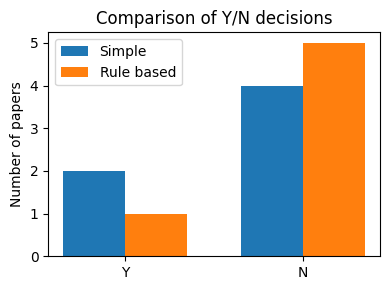

In [16]:
# Plot a bar chart comparing the number of Y and N labels.
labels = ["Y", "N"]
simple_vals = [simple_counts.get(l, 0) for l in labels]
rule_vals = [rule_counts.get(l, 0) for l in labels]

fig, ax = plt.subplots(figsize=(4, 3))

x = range(len(labels))
width = 0.35

ax.bar([i - width / 2 for i in x], simple_vals, width=width, label="Simple")
ax.bar([i + width / 2 for i in x], rule_vals, width=width, label="Rule based")

ax.set_xticks(list(x))
ax.set_xticklabels(labels)
ax.set_ylabel("Number of papers")
ax.set_title("Comparison of Y/N decisions")
ax.legend()

plt.tight_layout()
plt.show()


Even with only a few entries the bar chart makes the difference between the two schemes visible.

In a larger dataset you might see, for example:

- The simple classifier keeps many papers (`Y`) but has a high false positive rate.
- The rule based classifier is stricter and yields fewer `Y` labels but with higher precision.

We now extract the subset of papers that the **rule based classifier** marks as `Y`.  
These are our candidates for full text data mining.


In [17]:
df_selected = df_screen[df_screen["llm_rule_label"] == "Y"].copy()
df_selected


,doi,paper_title,abstract,file_location,llm_simple_label,llm_rule_label,llm_rule_rationale
3,10.1021/jacs.3c11688,Crystalline Polyphenylene Covalent Organic Fra...,The synthesis of crystalline polyphenylene cov...,https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/...,Y,Y,rational: Explicit synthesis of crystalline CO...


## 6. Extracting text from PDF full text

After screening by abstract, the next step is to work with the **full PDF** of a paper.

For each selected paper we want to:

1. Download the PDF using its `file_location` URL or local path.
2. Extract the raw text.
3. Inspect the first part of the text to understand the quality of the extraction.
4. Later, give the most relevant sections to an LLM for structured extraction.

The quality of PDF parsing can vary because PDFs are built for rendering rather than for easy text access.  
Nevertheless, `PyPDF2` can often extract enough information for an LLM to work with.


In [18]:
pdf_url = df_raw.iloc[3]["file_location"]

print("Using PDF URL:", pdf_url)
# Download the PDF content.


response = requests.get(pdf_url)
response.raise_for_status()

pdf_bytes = BytesIO(response.content)
reader = PdfReader(pdf_bytes)

print("Number of pages in PDF:", len(reader.pages))


Using PDF URL: https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/dist/0/4841/files/2025/06/crystalline-polyphenylene.pdf
Number of pages in PDF: 6


In [19]:
# Extract text from all pages into a single string.
all_text = ""
for page in reader.pages:
    text = page.extract_text() or ""
    all_text += text + "\n\n"

print("Total number of extracted characters:", len(all_text))
print("\nFirst 2000 characters of the text:\n")
print(all_text[:2000])


Total number of extracted characters: 26907

First 2000 characters of the text:

Crystalline Polyphenylene Covalent OrganicFrameworks
XingHan,ZihuiZhou,KaiyuWang,ZhilingZheng,S.EphraimNeumann, HeyangZhang,
Tianqiong Ma,andOmarM.Yaghi*
CiteThis:https://doi.org/10.1021/jacs.3c11688
 ReadOnline
ACCESS
 Metrics &More
 Article Recommendations +sıSupporting Information
ABSTRACT: Thesynthesis ofcrystalline polyphenylene covalent organic frameworks (COFs) wasaccomplished bylinking
fluorinated tris(4-acetylphenyl)benzene building unitsusingaldolcyclotrimerization. Thestructures ofthetwoCOFs,reported here,
wereconfirmed bypowder X-raydiffraction techniques, Fourier transform infrared, andsolid-state13CCP/MAS NMR
spectroscopy. Theresultsshowed thattheCOFswereporous andchemically stableincorrosive, harshenvironments foratleast1
week.Accordingly, postsynthetically modified derivatives oftheseCOFsusingprimary amines showed CO2uptakefromairandflue
gas.
Thechemistry ofcovalent organic frameworks (COFs

You should now see a large text block containing the title, author list, abstract, and the beginning of the main text.

Common issues when working with PDF text include:

- Line breaks inside sentences.
- Hyphenated words at line endings.
- Headers and footers interleaved with the main text.
- Mixed order of figure captions and main body text.

Despite these quirks, large language models are usually able to extract useful structured information from such text. Most of time, no extra text cleaning is needed.


Our next goal is to convert the noisy PDF text into **structured data** about experimental conditions.

For the selected COF paper we would like to extract, for each distinct synthesis condition:

- The organic linker.
- The solvent system.
- The reaction temperature in degrees Celsius (if given).
- The reaction time in hours (if given).
- Short notes about the condition.

We will approach this gradually:

1. Ask the model to produce a **markdown table** from a text block.  
2. Ask the model to return **JSON** without enforcing a schema.  
3. Use **Structured Outputs** so the model must obey a JSON schema that we define.


### 7.1 Extraction to a markdown table

We start with a simple prompt that asks the model to read a block of text and output a markdown table with the fields we care about.

Since the full `all_text` string might be long, we use only the first few thousand characters here.  
In a realistic workflow you might first identify the experimental section and then cut it into chunks.


In [20]:
# Take a shorter block of text for the example.
short_block = all_text[:4000]
print(short_block[:800])


Crystalline Polyphenylene Covalent OrganicFrameworks
XingHan,ZihuiZhou,KaiyuWang,ZhilingZheng,S.EphraimNeumann, HeyangZhang,
Tianqiong Ma,andOmarM.Yaghi*
CiteThis:https://doi.org/10.1021/jacs.3c11688
 ReadOnline
ACCESS
 Metrics &More
 Article Recommendations +sıSupporting Information
ABSTRACT: Thesynthesis ofcrystalline polyphenylene covalent organic frameworks (COFs) wasaccomplished bylinking
fluorinated tris(4-acetylphenyl)benzene building unitsusingaldolcyclotrimerization. Thestructures ofthetwoCOFs,reported here,
wereconfirmed bypowder X-raydiffraction techniques, Fourier transform infrared, andsolid-state13CCP/MAS NMR
spectroscopy. Theresultsshowed thattheCOFswereporous andchemically stableincorrosive, harshenvironments foratleast1
week.Accordingly, postsynthetically modified derivati


In [21]:
def make_condition_table_prompt(text_block):
    # Build a prompt that requests a markdown table of synthesis conditions.
    prompt = (
        "You are an expert experimental chemist reading a methods section for a metal-organic framework.\n"
        "From the text below, extract each distinct synthesis condition related to framework preparation.\n\n"
        "For each condition, record:\n"
        "- linker (short name or formula).\n"
        "- solvent_system (one primary solvent) No need to include modulator.\n"
        "- temperature_C (numeric value if available, otherwise null).\n"
        "- time_h (numeric value in hours if available, otherwise null).\n"
        "- notes (very short description, fewer than 15 words).\n\n"
        "Return the result as a markdown table with columns:\n"
        "linker | solvent_system | temperature_C | time_h | notes\n\n"
        "Text to analyze:\n"
        f"{text_block}"
    )
    return prompt

prompt_table = make_condition_table_prompt(short_block)
print(prompt_table[:700])


You are an expert experimental chemist reading a methods section for a metal-organic framework.
From the text below, extract each distinct synthesis condition related to framework preparation.

For each condition, record:
- linker (short name or formula).
- solvent_system (one primary solvent) No need to include modulator.
- temperature_C (numeric value if available, otherwise null).
- time_h (numeric value in hours if available, otherwise null).
- notes (very short description, fewer than 15 words).

Return the result as a markdown table with columns:
linker | solvent_system | temperature_C | time_h | notes

Text to analyze:
Crystalline Polyphenylene Covalent OrganicFrameworks
XingHan,Zihui


In [22]:
response_table = client.responses.create(
    model="gpt-5",
    input=[{"role": "user", "content": [{"type": "input_text", "text": prompt_table}]}],
    reasoning={"effort": "medium"},
)

table_text = response_table.output_text
print(table_text)


| linker | solvent_system | temperature_C | time_h | notes |
|---|---|---|---|---|
| TAB | 1,4-dioxane | 85 | 72 | solvothermal; 1,4-dioxane/m-xylene; aqueous TfOH catalyst; moderate yield |


The model output should be a markdown table with a header row and one row per condition.

You can quickly check the table by copying it into a markdown cell or by printing it again in a clean cell.

Next we convert this markdown table into a pandas DataFrame.


In [23]:
def markdown_table_to_dataframe(table_text):
    # Convert a simple pipe separated markdown table into a DataFrame.
    lines = [line.strip() for line in table_text.splitlines() if line.strip()]

    # Keep only lines that look like table rows.
    lines = [line for line in lines if "|" in line]
    if not lines:
        return pd.DataFrame()

    # Parse header
    header = [col.strip() for col in lines[0].split("|")]

    rows = []
    for line in lines[1:]:
        parts = [col.strip() for col in line.split("|")]

        # Skip lines that do not match header length
        if len(parts) != len(header):
            continue

        rows.append(parts)

    df = pd.DataFrame(rows, columns=header)

    # Drop any rows where ANY column contains '---'
    mask = df.apply(lambda row: row.str.contains('---')).any(axis=1)
    df = df[~mask].reset_index(drop=True)

    return df
df_conditions_table = markdown_table_to_dataframe(table_text)
df_conditions_table


,,linker,solvent_system,temperature_C,time_h,notes,
0,,TAB,"1,4-dioxane",85,72,"solvothermal; 1,4-dioxane/m-xylene; aqueous Tf...",


### 7.2 Asking for JSON output

Markdown tables are convenient for humans, but JSON is more natural for code.

We now adjust the prompt so that the model returns only a JSON array of condition objects.  
Each object should have keys `metal_source`, `linker`, `solvent_system`, `temperature_C`, `time_h`, and `notes`.


In [24]:
import json

def make_condition_json_prompt(text_block):
    prompt = (
        "You are an expert experimental chemist.\n"
        "From the text below, extract a list of synthesis conditions related to framework formation.\n"
        "For each condition, create an object with keys:\n"
        "- linker (short string).\n"
        "- solvent_system (one primary solvent) No need to include modulator.\n"
        "- temperature_C (number or null).\n"
        "- time_h (number or null).\n"
        "- notes (short string).\n\n"
        "Return ONLY a JSON array, with no extra text.\n\n"
        "Text to analyze:\n"
        f"{text_block}"
    )
    return prompt

prompt_json = make_condition_json_prompt(short_block)
print(prompt_json[:600])


You are an expert experimental chemist.
From the text below, extract a list of synthesis conditions related to framework formation.
For each condition, create an object with keys:
- linker (short string).
- solvent_system (one primary solvent) No need to include modulator.
- temperature_C (number or null).
- time_h (number or null).
- notes (short string).

Return ONLY a JSON array, with no extra text.

Text to analyze:
Crystalline Polyphenylene Covalent OrganicFrameworks
XingHan,ZihuiZhou,KaiyuWang,ZhilingZheng,S.EphraimNeumann, HeyangZhang,
Tianqiong Ma,andOmarM.Yaghi*
CiteThis:https://doi.o


In [25]:
response_json = client.responses.create(
    model="gpt-5",
    input=[{"role": "user", "content": [{"type": "input_text", "text": prompt_json}]}],
    reasoning={"effort": "medium"},
    store=False
)

raw_json_text = response_json.output_text
print(raw_json_text[:800])


[
  {
    "linker": "TAB",
    "solvent_system": "1,4-dioxane",
    "temperature_C": 85,
    "time_h": 72,
    "notes": "COF-284; solvothermal; mixture with m-xylene; aqueous TfOH catalyst; moderate yield"
  }
]


In [26]:
# Parse the JSON string into Python data.
try:
    conditions_list = json.loads(raw_json_text)
except json.JSONDecodeError as e:
    print("Error parsing JSON:", e)
    conditions_list = []

print("Parsed type:", type(conditions_list))
print("Number of entries:", len(conditions_list))

if conditions_list:
    print("First entry:")
    print(json.dumps(conditions_list[0], indent=2))


Parsed type: <class 'list'>
Number of entries: 1
First entry:
{
  "linker": "TAB",
  "solvent_system": "1,4-dioxane",
  "temperature_C": 85,
  "time_h": 72,
  "notes": "COF-284; solvothermal; mixture with m-xylene; aqueous TfOH catalyst; moderate yield"
}


At this point we have a list of Python dictionaries describing synthesis conditions.  
But we have not yet enforced a schema, so field types might be inconsistent.

For example:

- `temperature_C` could be `"120"` in one entry and `120` (a number) in another.
- Some entries might omit `time_h` entirely.

This is where **Structured Outputs** help by enforcing a schema defined in advance.


### 7.3 Structured Outputs with Pydantic

The OpenAI Python SDK can use Pydantic models to define the structure of the desired output.

We create two models:

- `Condition` for a single synthesis condition.
- `ConditionExtraction` which just wraps a list of `Condition` objects.

The helper `client.responses.parse` sends these models to the API and validates the result.


In [27]:
from pydantic import BaseModel
from typing import List, Optional

class Condition(BaseModel):
    metal_source: str
    linker: str
    solvent_system: str
    temperature_C: Optional[float]
    time_h: Optional[float]
    notes: str

class ConditionExtraction(BaseModel):
    conditions: List[Condition]


In [28]:
structured_response = client.responses.parse(
    model="gpt-5",
    input=[
        {
            "role": "system",
            "content": "Extract synthesis conditions from the given text into the ConditionExtraction schema.",
        },
        {
            "role": "user",
            "content": [
                {"type": "input_text", "text": short_block},
            ],
        },
    ],
    text_format=ConditionExtraction, #here is where we tell gpt what structure to output
)

parsed_conditions = structured_response.output_parsed
parsed_conditions


ConditionExtraction(conditions=[Condition(metal_source='', linker='TAB (1,3,5-trifluoro-2,4,6-tris(4-acetylphenyl)benzene)', solvent_system='1,4-dioxane/m-xylene; aqueous TfOH (trifluoromethanesulfonic acid) catalyst', temperature_C=85.0, time_h=72.0, notes='Solvothermal aldol cyclotrimerization to form COF-284; reported as moderate yield.')])

In [29]:
# Turn the parsed Pydantic object into a DataFrame.
rows = [cond.model_dump() for cond in parsed_conditions.conditions]
df_conditions = pd.DataFrame(rows)
df_conditions


,metal_source,linker,solvent_system,temperature_C,time_h,notes
0,,"TAB (1,3,5-trifluoro-2,4,6-tris(4-acetylphenyl...","1,4-dioxane/m-xylene; aqueous TfOH (trifluorom...",85.0,72.0,Solvothermal aldol cyclotrimerization to form ...


With Structured Outputs you should see:

- All required keys present in every row.
- Numeric values for `temperature_C` and `time_h` where possible.
- Empty values represented as `NaN` after DataFrame conversion.



## 8. Image based figure mining with vision models

Many experimental details appear not only in text but also in **figures**.  

Today we will try to take following three as examples, but you can image there exist dozens of then:

- PXRD patterns that confirm crystallinity and phase purity.
- SEM micrographs that show particles / surface.
- Bioimaging panels that reveal cellular uptake or localization.

Vision enabled LLMs can analyze images directly, which opens a path to **automated figure mining**.  
Here we practice with the PDF of the selected paper by:

1. Converting each page to an image.
2. Asking the model whether a page contains PXRD, SEM, or bioimaging content.
3. Collecting the results into a summary table.


### 8.1 Rendering PDF pages as images

We use the `pdf2image` package to convert the raw PDF bytes into a list of PIL images, one per page.

> Important: `pdf2image` may require an external tool such as `poppler` to be installed on your system.  
> If you cannot install it, you can still read the code in this section and adapt it later on another machine.


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.12 [186 kB]
Fetched 186 kB in 0s (2,012 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121703 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.12_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.12) ...
Setting up poppler-utils (22.02.0-2ubuntu0.12) ...
Processing triggers for man-db (2.10.2-1) ...
Number of pages: 13


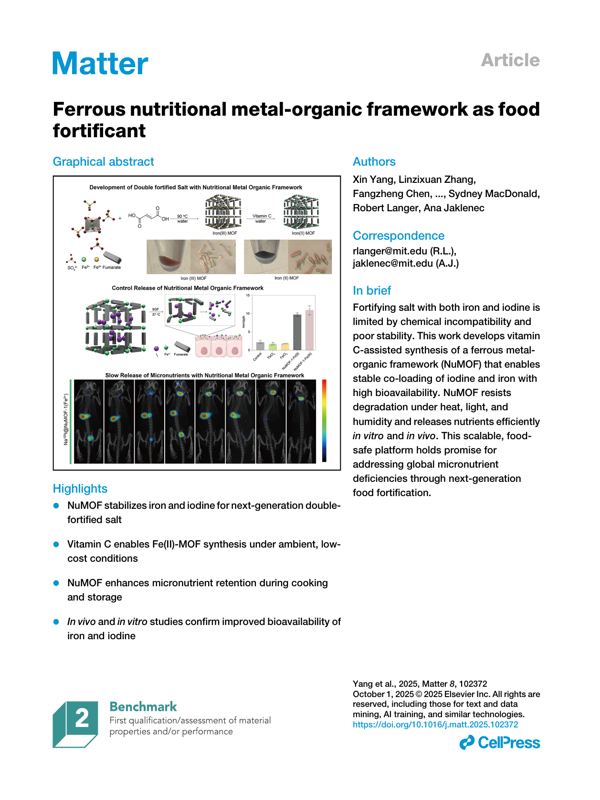

In [30]:
import requests
from pdf2image import convert_from_bytes
!apt-get install -y poppler-utils

url = "https://bpb-us-e2.wpmucdn.com/sites.wustl.edu/dist/0/4841/files/2025/08/ferrous-nutritional.pdf"

# Fetch PDF
response = requests.get(url)
response.raise_for_status()

# Render pages
pages = convert_from_bytes(response.content, dpi=150)

print("Number of pages:", len(pages))

# Show first page in Jupyter
display(pages[0].resize((600, 800)))

If rendering works, you should see the first page of the PDF as an image.  
When the resolution is too low, details in PXRD or SEM plots may be hard for the model to read, so a moderate `dpi` such as 150 or 200 is often a good compromise.

Next, we prepare helper functions to encode an image to base64 and send it to the Responses API together with text instructions.


In [31]:
import base64
def encode_pil_image_to_base64(img):
    # Encode a PIL Image object as a base64 PNG string.
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    b64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return b64

first_page = pages[0]
# Example Encode that page
encoded = encode_pil_image_to_base64(first_page)

print("Base64 length:", len(encoded))
print("Encoded first 200 char:",encoded[:200] + "...")

Base64 length: 725732
Encoded first 200 char: iVBORw0KGgoAAAANSUhEUgAABOkAAAZgCAIAAACk44QcAAEAAElEQVR4nOzdd3wT9f8H8E9GM5ruvSm0ZRbKKHvvIUiRPUUBmaK4URkCil83AoKCygYZglIEmWW2Ze8WCqV77zZJM+/3x2l+4e6Spm3aBnw9H/xRPvnkc59cLnf3vs/iURRFAAAAAAAAAGwYv6ErAAAA...


You will see after encoding it becomes something like `iVBORw0KGgoAAAANSUhEUgAABOkAAAZgCAIA...` that's the input we will bring LLM with for them to "see" this page. For more information, feel free to review Lecture 23 - Vision Language Model content.

### 8.2 Asking targeted questions about a single page

We define a function that takes a page image and asks three questions:

1. `Q1`: Does this page contain a PXRD pattern?  
2. `Q2`: Does this page contain SEM images?  
3. `Q3`: Does this page contain any bioimaging (cells, tissues, in vivo imaging)?

We request a very structured answer:

- For each question, a line `Qx: Y` or `Qx: N`.  
- Immediately followed by a line starting with `Rational:` that justifies the decision in fewer than 20 words.


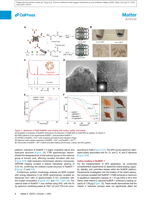

Raw model text for page 5:
Q1: Y  
Rational: The page includes a plot for the PXRD pattern in section C.

Q2: N  
Rational: There are no SEM images provided on this page.

Q3: N  
Rational: No plots related to fluorescence or bioluminescence are shown.

Parsed result for page 4: {'page': 5, 'pxrd': 'Y', 'sem': 'N', 'bioimaging': 'N', 'rational_pxrd': 'Rational: The page includes a plot for the PXRD pattern in section C.', 'rational_sem': 'Rational: There are no SEM images provided on this page.', 'rational_bio': 'Rational: No plots related to fluorescence or bioluminescence are shown.'}


In [32]:
def ask_figure_types_on_page(img, page_number):
    b64_image = encode_pil_image_to_base64(img)

    user_content = [
        {
            "type": "input_text",
            "text": (
                f"You are an expert in materials characterization.\n"
                f"Look at page {page_number} of a PDF and answer three questions.\n\n"
                "For each question, respond with two lines:\n"
                "Qx: Y or N\n"
                "Rational: short explanation, fewer than 20 words.\n\n"
                "Questions:\n"
                "Q1: Does this page contain a plot for PXRD pattern?\n"
                "Q2: Does this page contain a plot for SEM images?\n"
                "Q3: Does this page contain any plots with fluorescence or bioluminescence?"
            ),
        },
        {
            "type": "input_image",
            "image_url": f"data:image/png;base64,{b64_image}",
        },
    ]

    response = client.responses.create(
        model="gpt-4o-mini",
        input=[{"role": "user", "content": user_content}],
        max_output_tokens=500,
        store=False,
    )

    text = response.output_text
    print(f"Raw model text for page {page_number}:\n{text}\n")

    # Parse the text output into a small dictionary.
    lines = [line.strip() for line in text.splitlines() if line.strip()]
    result = {
        "page": page_number,
        "pxrd": "",
        "sem": "",
        "bioimaging": "",
        "rational_pxrd": "",
        "rational_sem": "",
        "rational_bio": "",
    }

    current_q = None
    for line in lines:
        if line.startswith("Q1"):
            current_q = "Q1"
            if "Y" in line.upper():
                result["pxrd"] = "Y"
            elif "N" in line.upper():
                result["pxrd"] = "N"
        elif line.startswith("Q2"):
            current_q = "Q2"
            if "Y" in line.upper():
                result["sem"] = "Y"
            elif "N" in line.upper():
                result["sem"] = "N"
        elif line.startswith("Q3"):
            current_q = "Q3"
            if "Y" in line.upper():
                result["bioimaging"] = "Y"
            elif "N" in line.upper():
                result["bioimaging"] = "N"
        elif line.lower().startswith("rational"):
            if current_q == "Q1":
                result["rational_pxrd"] = line
            elif current_q == "Q2":
                result["rational_sem"] = line
            elif current_q == "Q3":
                result["rational_bio"] = line

    return result

page_images = pages

# test the function on page 4.
display(pages[4].resize((150, 200)))
result_page4 = ask_figure_types_on_page(page_images[4], page_number=5)
print("Parsed result for page 4:", result_page4)

We can also test on another page 9:

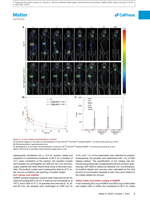

Raw model text for page 10:
Q1: N  
Rationale: The page does not include a PXRD pattern plot.

Q2: N  
Rationale: There are no SEM images presented on this page.

Q3: Y  
Rationale: The page features fluorescence imaging related to iodine absorption in mice.

Parsed result for page 9: {'page': 10, 'pxrd': 'N', 'sem': 'N', 'bioimaging': 'Y', 'rational_pxrd': 'Rationale: The page does not include a PXRD pattern plot.', 'rational_sem': 'Rationale: There are no SEM images presented on this page.', 'rational_bio': 'Rationale: The page features fluorescence imaging related to iodine absorption in mice.'}


In [33]:
display(pages[9].resize((150, 200)))
result_page9 = ask_figure_types_on_page(page_images[9], page_number=10)
print("Parsed result for page 9:", result_page9)

Putting everything together, below is an example on having LLM read all pages in this dataset and annoate the presence of 20+ different types of plots at one time.

In [50]:
import re
import json

# -------------------------------------------------------------------
# Load dataset
# -------------------------------------------------------------------
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/data_mining_papers.csv"
df_raw = pd.read_csv(url).dropna(how="all").reset_index(drop=True)

# -------------------------------------------------------------------
# Choose how many papers to process:
#   NUM_PAPERS = 1      -> only first paper
#   NUM_PAPERS = 3      -> first 3 papers
#   NUM_PAPERS = None   -> all papers
# -------------------------------------------------------------------
NUM_PAPERS = None

if NUM_PAPERS is None:
    df_subset = df_raw
else:
    df_subset = df_raw.head(NUM_PAPERS)

print(f"Processing {len(df_subset)} paper(s):")

# -------------------------------------------------------------------
# Classification helper
# -------------------------------------------------------------------

FIG_LABELS = [
    "pxrd",
    "tga",
    "n2_sorption",
    "co2_sorption",
    "h2o_sorption",
    "pore_size_distribution",
    "sem",
    "tem",
    "crystal_structure",
    "organic_reaction_scheme",
    "organic_synthesis_setup",
    "bioimaging",
    "energy_diagram",
    "catalytic_performance",
    "nmr_spectra",
    "ftir_spectra",
    "uv_vis_spectra",
    "pl_spectra",
    "xps_spectra",
    "contact_angle",
]

def classify_page(img, page_number, model_name="gpt-5.1"):
    """
    Classify a single PDF page image into MOF/COF-related figure types.
    Uses both the visual content and the associated figure caption text
    that appears in the page image.
    """
    b64_image = encode_pil_image_to_base64(img)

    prompt = f"""
You are an expert in MOF/COF materials characterization and catalysis.
You are analyzing page {page_number} of a scientific PDF. The image you see is the full page.

Your task:
- Inspect only figures on the page, including their panel labels and the visible figure captions.
- Ignore tables and unrelated body paragraphs that are not clearly tied to a figure.

For each category below, you must mark "Y" only when BOTH conditions are true:
  (1) The figure visually matches the description of that category.
  (2) The associated figure caption or panel label clearly supports that interpretation
      (for example, it mentions PXRD, TGA, CO2 adsorption, catalytic activity, etc).

If only the caption suggests a category but the plot/image looks different, answer "N".
If the image looks similar but the caption does not support that interpretation, answer "N".
Be very careful and only include very relevant, clearly matching figures. If you are not sure, answer "N".

Categories:

- pxrd: powder X-ray diffraction patterns (intensity vs 2θ or 2-theta, sharp diffraction peaks).
- tga: thermogravimetric analysis (mass or mass% vs temperature, sometimes with DTG curves).
- n2_sorption: N2 adsorption/desorption isotherms, often at 77 K, amount adsorbed vs relative pressure (P/P0).
- co2_sorption: CO2 adsorption/desorption isotherms, amount adsorbed vs pressure or P/P0 with CO2 mentioned.
- h2o_sorption: H2O or water vapor sorption isotherms, amount adsorbed vs relative humidity or P/P0 with water mentioned.
- pore_size_distribution: pore size distribution plots (dV/dlog(r) vs pore diameter, or similar).
- sem: scanning electron microscopy images of particles, crystals, films, or morphologies.
- tem: transmission electron microscopy images, often showing lattice fringes or internal structure.
- crystal_structure: MOF or COF crystal structures or models (ball-and-stick, stick-and-rod, pore channels, unit cells).
- organic_reaction_scheme: reaction schemes with reagents, arrows, and products, typically synthetic transformations.
- organic_synthesis_setup: multi-step organic synthesis routes or synthetic pathways, often combining several steps or intermediates.
- bioimaging: fluorescence or bioluminescence images of cells, tissues, or animals (confocal images, in vivo imaging).
- energy_diagram: computational or mechanistic energy diagrams (reaction coordinate vs energy, with multiple minima and barriers).
- catalytic_performance: catalytic performance plots (yield, conversion, selectivity, TON/TOF, or rate vs time, cycles, or conditions).
- nmr_spectra: NMR spectra (1H, 13C, etc), chemical shift vs intensity, with peaks and ppm scale.
- ftir_spectra: FTIR spectra (transmittance or absorbance vs wavenumber, usually 4000-400 cm^-1).
- uv_vis_spectra: UV-Vis absorption spectra (absorbance vs wavelength).
- pl_spectra: photoluminescence or emission spectra (intensity vs wavelength, often with excitation/emission labels).
- xps_spectra: X-ray photoelectron spectroscopy plots (intensity vs binding energy).
- contact_angle: contact angle images showing a liquid droplet on a surface with the contact angle indicated.

Respond with one valid JSON object only, exactly in this schema:

{{
  "pxrd": "Y" or "N",
  "tga": "Y" or "N",
  "n2_sorption": "Y" or "N",
  "co2_sorption": "Y" or "N",
  "h2o_sorption": "Y" or "N",
  "pore_size_distribution": "Y" or "N",
  "sem": "Y" or "N",
  "tem": "Y" or "N",
  "crystal_structure": "Y" or "N",
  "organic_reaction_scheme": "Y" or "N",
  "organic_synthesis_setup": "Y" or "N",
  "bioimaging": "Y" or "N",
  "energy_diagram": "Y" or "N",
  "catalytic_performance": "Y" or "N",
  "nmr_spectra": "Y" or "N",
  "ftir_spectra": "Y" or "N",
  "uv_vis_spectra": "Y" or "N",
  "pl_spectra": "Y" or "N",
  "xps_spectra": "Y" or "N",
  "contact_angle": "Y" or "N"
}}

Rules:
- Answer with exactly one JSON object and nothing else.
- Use "Y" only when the evidence from both the figure and its caption is strong.
- If there are several figures or panels on a page, mark "Y" for a category if at least one panel matches it.
- If image is not visible, use "N" to all
- If a page is full of text, use "N" to all
- When in doubt or anything missing, use "N".
"""

    user_content = [
        {"type": "input_text", "text": prompt},
        {
            "type": "input_image",
            "image_url": f"data:image/png;base64,{b64_image}",
            "detail": "low",
        },
    ]

    response = client.responses.create(
        model=model_name,
        input=[{"role": "user", "content": user_content}],
    )

    raw = (getattr(response, "output_text", None) or "").strip()

    # Strip accidental ```json fences if present
    if raw.startswith("```"):
        raw = re.sub(r"^```(?:json)?", "", raw, flags=re.IGNORECASE).strip()
        raw = re.sub(r"```$", "", raw).strip()

    # Default values
    result = {"page": page_number}
    for key in FIG_LABELS:
        result[key] = "N"

    try:
        data = json.loads(raw)
        if isinstance(data, dict):
            for key in FIG_LABELS:
                if key in data and data[key] in ["Y", "N"]:
                    result[key] = data[key]
    except Exception as e:
        print(f"  Warning: JSON parse error on page {page_number}: {e}")
        print("  Model output:", raw)

    return result


# -------------------------------------------------------------------
# Process all selected papers
# -------------------------------------------------------------------
all_page_rows = []

for i, row in df_subset.iterrows():
    doi = row["doi"]
    file_url = row["file_location"]

    print(f"\nPaper {i + 1}/{len(df_subset)} | DOI: {doi}")

    try:
        pdf_resp = requests.get(file_url)
        pdf_resp.raise_for_status()
        pages = convert_from_bytes(pdf_resp.content, dpi=150)
        n_pages = len(pages)
        print(f"  Pages: {n_pages}")

        for idx, img in enumerate(pages):
            page_no = idx + 1
            if page_no == 1 or page_no == n_pages or page_no % 5 == 0:
                print(f"    Classifying page {page_no}/{n_pages}")

            page_result = classify_page(img, page_number=page_no)
            page_result["doi"] = doi
            all_page_rows.append(page_result)

    except Exception as e:
        print(f"  Error processing PDF for DOI {doi}: {e}")
        continue

# -------------------------------------------------------------------
# Final dataframe with all pages and all figure types
# -------------------------------------------------------------------
df_figures = pd.DataFrame(all_page_rows)[["doi", "page"] + FIG_LABELS]
df_figures


Processing 6 paper(s):

Paper 1/6 | DOI: 10.1021/jacs.3c12086
  Pages: 12
    Classifying page 1/12
    Classifying page 5/12
    Classifying page 10/12
    Classifying page 12/12

Paper 2/6 | DOI: 10.1021/acs.inorgchem.5c01817
  Pages: 10
    Classifying page 1/10
    Classifying page 5/10
    Classifying page 10/10

Paper 3/6 | DOI: 10.1016/j.matt.2025.102372
  Pages: 13
    Classifying page 1/13
    Classifying page 5/13
    Classifying page 10/13
    Classifying page 13/13

Paper 4/6 | DOI: 10.1021/jacs.3c11688
  Pages: 6
    Classifying page 1/6
    Classifying page 5/6
    Classifying page 6/6

Paper 5/6 | DOI: 10.1021/acs.inorgchem.3c02322
  Pages: 13
    Classifying page 1/13
    Classifying page 5/13
    Classifying page 10/13
    Classifying page 13/13

Paper 6/6 | DOI: 10.1038/s41467-020-18427-3
  Pages: 8
    Classifying page 1/8
    Classifying page 5/8
    Classifying page 8/8


,doi,page,pxrd,tga,n2_sorption,co2_sorption,h2o_sorption,pore_size_distribution,sem,tem,...,organic_synthesis_setup,bioimaging,energy_diagram,catalytic_performance,nmr_spectra,ftir_spectra,uv_vis_spectra,pl_spectra,xps_spectra,contact_angle
0,10.1021/jacs.3c12086,1,N,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N
1,10.1021/jacs.3c12086,2,N,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N
2,10.1021/jacs.3c12086,3,N,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N
3,10.1021/jacs.3c12086,4,Y,N,Y,N,Y,N,N,N,...,N,N,N,N,N,N,N,N,N,N
4,10.1021/jacs.3c12086,5,N,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,10.1038/s41467-020-18427-3,4,N,N,N,N,N,N,Y,Y,...,N,N,N,N,N,N,N,N,N,N
58,10.1038/s41467-020-18427-3,5,N,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N
59,10.1038/s41467-020-18427-3,6,N,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N
60,10.1038/s41467-020-18427-3,7,N,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N


Now you can quickly look up a certain type of plot based on the label assigned by LLM:

=== Building page matrix by category and DOI ===

Found 3 pages for category 'n2_sorption'.
Building composite of up to 2 pages.

Composite for category 'n2_sorption' (600x400):


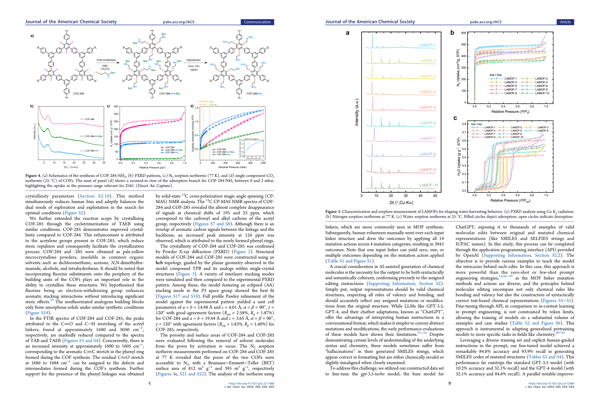

Found 2 pages for category 'sem'.
Building composite of up to 2 pages.

Composite for category 'sem' (600x400):


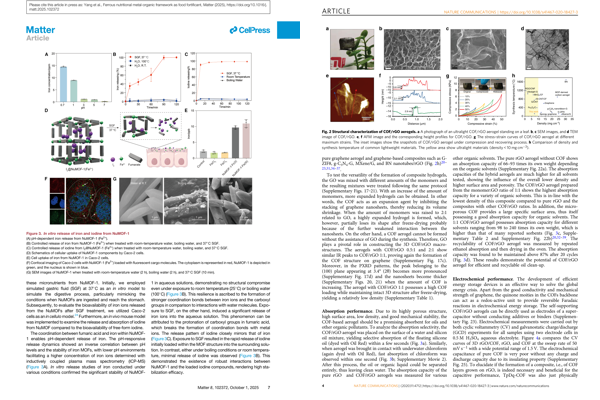

Found 2 pages for category 'bioimaging'.
Building composite of up to 2 pages.

Composite for category 'bioimaging' (600x400):


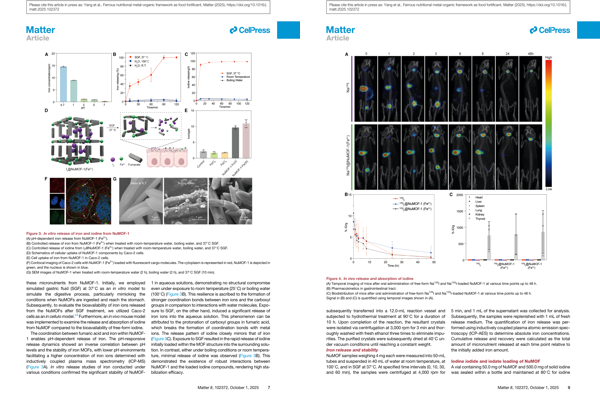

Found 1 pages for category 'tga'.
Building composite of up to 2 pages.

Composite for category 'tga' (600x400):


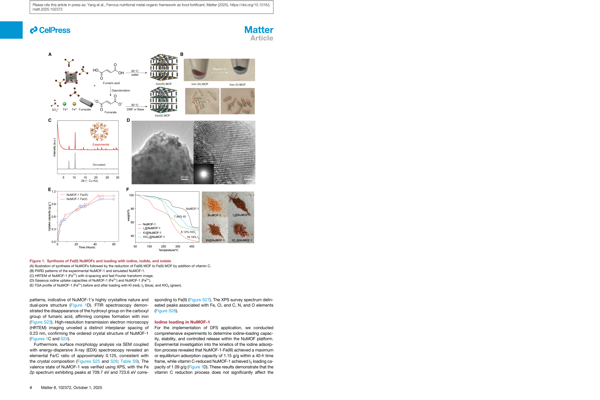

,10.1016/j.matt.2025.102372,10.1021/acs.inorgchem.3c02322,10.1021/acs.inorgchem.5c01817,10.1021/jacs.3c11688,10.1021/jacs.3c12086,10.1038/s41467-020-18427-3
pxrd,page 5,,,"page 2, page 3, page 4",page 4,page 3
tga,page 5,,,,,
n2_sorption,,,,page 3,page 4,page 3
co2_sorption,,,,page 3,,
h2o_sorption,,,,,"page 4, page 7",
pore_size_distribution,,,,,,page 3
sem,page 8,,,,,page 4
tem,page 5,,,,,page 4
crystal_structure,"page 1, page 8","page 1, page 2, page 5, page 6, page 7, page 8","page 1, page 3, page 5, page 6, page 7",page 2,"page 2, page 8",page 3
organic_reaction_scheme,page 5,,page 8,"page 1, page 3",page 3,


In [58]:
from PIL import Image

# 1) Build DF: rows = figure categories, columns = paper DOIs, values = "page x, page y"

print("=== Building page matrix by category and DOI ===\n")

# All figure-type columns are everything except doi and page
figure_cols = [c for c in df_figures.columns if c not in ["doi", "page"]]

dois = sorted(df_figures["doi"].unique().tolist())

# Prepare a dict of columns for the final dataframe
matrix_data = {doi: [] for doi in dois}

for col in figure_cols:
    for doi in dois:
        pages = (
            df_figures.loc[
                (df_figures["doi"] == doi) & (df_figures[col] == "Y"),
                "page",
            ]
            .sort_values()
            .tolist()
        )
        if pages:
            page_strs = [f"page {p}" for p in pages]
            value = ", ".join(page_strs)
        else:
            value = ""
        matrix_data[doi].append(value)

# Rows are categories, columns are DOIs
df_pages_by_category = pd.DataFrame(matrix_data, index=figure_cols)



# 2) Helper to collect up to N pages for any category and make a composite

def build_composite_for_category(
    category,
    max_panels=2,
    canvas_size=(600, 400),
    grid=(2, 1),
    dpi=150,
):
    """
    Build a grid composite image for a given figure category.

    category: one of the df_figures columns such as
              'pxrd', 'tga', 'n2_sorption', 'co2_sorption',
              'h2o_sorption', 'pore_size_distribution', 'sem',
              'tem', 'crystal_structure', 'organic_reaction_scheme',
              'organic_synthesis_setup', 'bioimaging', 'energy_diagram',
              'catalytic_performance', 'nmr_spectra', 'ftir_spectra',
              'uv_vis_spectra', 'pl_spectra', 'xps_spectra',
              'contact_angle', etc.
    """

    if category not in df_figures.columns:
        raise ValueError(f"Category '{category}' is not a column in df_figures")

    pages_global = df_figures[df_figures[category] == "Y"].copy()
    pages_global = pages_global.sort_values(["doi", "page"]).reset_index(drop=True)

    if pages_global.empty:
        print(f"No pages found for category '{category}'. Composite figure will not be created.")
        return

    print(f"Found {len(pages_global)} pages for category '{category}'.")
    print(f"Building composite of up to {max_panels} pages.\n")

    # Select first N pages with that category
    selected = pages_global.head(max_panels)

    # Cache PDFs by DOI to avoid repeated downloads
    pdf_cache = {}  # doi -> list of page images
    images_for_grid = []

    for _, row in selected.iterrows():
        doi = row["doi"]
        page_no = int(row["page"])

        if doi not in pdf_cache:
            file_url = df_raw.loc[df_raw["doi"] == doi, "file_location"].iloc[0]
            pdf_resp = requests.get(file_url)
            pdf_resp.raise_for_status()
            pdf_pages = convert_from_bytes(pdf_resp.content, dpi=dpi)
            pdf_cache[doi] = pdf_pages

        pdf_pages = pdf_cache[doi]
        if 1 <= page_no <= len(pdf_pages):
            img = pdf_pages[page_no - 1]
            images_for_grid.append(img)
        else:
            print(f"Warning: page {page_no} out of range for DOI {doi}")

    if not images_for_grid:
        print(f"Could not collect any images for category '{category}' to display.")
        return

    # 3) Make composite grid on a canvas
    canvas_w, canvas_h = canvas_size
    cols, rows = grid
    panel_w = canvas_w // cols
    panel_h = canvas_h // rows

    composite = Image.new("RGB", (canvas_w, canvas_h), color="white")

    for idx, img in enumerate(images_for_grid[: cols * rows]):
        r = idx // cols
        c = idx % cols

        # Resize image into its panel
        panel = img.resize((panel_w, panel_h))

        x = c * panel_w
        y = r * panel_h
        composite.paste(panel, (x, y))

    print(f"Composite for category '{category}' ({canvas_w}x{canvas_h}):")
    display(composite)


# Example: build composites
build_composite_for_category("n2_sorption")
build_composite_for_category("sem")
build_composite_for_category("bioimaging")
build_composite_for_category("tga")
# Show the matrix dataframe
df_pages_by_category

## 9. Glossary

> **Literature data mining**: The process of extracting structured information (methods, data, trends) from scientific papers.

> **Structured output**: A model response constrained to follow a defined format, such as JSON, ensuring type consistency.

> **Reasoning effort**: A model control parameter indicating how much logical or interpretive reasoning should be applied.

> **Domain heuristic**: A rule of thumb drawn from expert knowledge that guides model interpretation.

> **Abstract triage**: Early filtering of papers based on their abstracts before detailed reading.

> **JSON Schema**: A formal structure defining what keys, types, and formats a valid JSON object must contain.

> **Multimodal model**: A model that processes both text and visual inputs—useful for reading figures and images.







